First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [254]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#!pip install -r requirements.txt
#!pip install "numpy==1.26.4" "pandas==2.1.4"
#!pip install plotly
#!pip uninstall -y starvers
#!pip install plotly
#!pip install seaborn

In [255]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [256]:
executed_by ='stud-id_11906257'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [257]:
# group id for this project
group_id = '39'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12402153'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_11906257'  # Replace the digits after "id_" with student B's student ID

In [258]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [259]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [260]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    'qudt-unit': 'http://qudt.org/vocab/unit/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [261]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [262]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Poj" .',
f':{student_a} foaf:familyName "Netsiri" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "12402153" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "01234567"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Michael" .',
f':{student_b} foaf:familyName "Wolkerstorfer" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "11906257" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "76543210"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]

engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [263]:
superstore_data_path = "data"


## 1. Business Understanding 

In [264]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


**a. Define and describe the data source and a scenario in which a business analytics task based on the data set you identified should be solved.**

In [265]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
Dataset: Superstore Dataset
Source: https://www.kaggle.com/datasets/vivek468/superstore-dataset-final

The dataset contains order-level retail information:
- Order/Ship Dates
- Customer, Segment, Region
- Product Category, Sub-Category
- Sales (prediction target)
- Quantity, Discount
- Profit (used only for interpretation)

Scenario:
A retail company aims to improve order-level sales forecasting. Better sales prediction supports
pricing strategy, promotion planning, and more accurate demand and inventory management.
"""

**b. Clearly define and describe the Business Objectives.**

In [266]:
#############################################
# Documentation
#############################################

business_objectives_comment = """
Primary Business Objective:
Predict sales at the order level to strengthen revenue planning and operational decision-making.

Secondary Objectives:
- Identify key drivers of sales (e.g., category, discount, region).
- Improve pricing and promotion decisions.
- Support inventory allocation and demand planning.
- Highlight high-performing regions and product lines.
"""

**c. Clearly define and describe the Business Success Criteria.**

In [267]:
#############################################
# Documentation
#############################################

business_success_criteria_comment = """
Business Success Criteria:
- Improved forecasting accuracy that reduces stockouts and overstocking.
- More informed pricing and discount decisions.
- Fewer low-value or unprofitable orders.
- Adoption of predictions in operational workflows.
"""

**d. Clearly define and describe the Data Mining Goals.**

In [268]:
#############################################
# Documentation
#############################################

data_mining_goals_comment = """
Data Mining (ML) Goals:
- Build a regression model to predict Sales based on order characteristics.
- Engineer interpretable features (date fields, category aggregates).
- Avoid data leakage by excluding Profit and profit-derived attributes.
- Achieve stable generalization performance.
- Identify meaningful factors influencing sales.
"""

**e. Clearly define and describe the Data Mining Success Criteria.**

In [269]:
#############################################
# Documentation
#############################################

data_mining_success_criteria_comment = """
Data Mining Success Criteria:
- Achieve acceptable predictive performance (reasonable R² and RMSE).
- No overfitting (similar training and test results).
- Stable feature importance rankings.
- No missing-value issues or target leakage.
"""

**f. Are there any AI risk aspects that may require specific consideration?**

In [270]:
#############################################
# Documentation
#############################################

ai_risk_aspects_comment = """
AI Risk Aspects:
1. Data Leakage:
   Profit or post-outcome information must not appear in the features.

2. Bias:
   Historical patterns may bias results toward specific regions or customer groups.

3. Over-Reliance:
   Sales depend on external factors not captured in the dataset (seasonality, supply issues).

4. Model Misuse:
   Automated discounting or pricing actions may lead to unfair treatment.

5. Explainability:
   Transparent reasoning is necessary for stakeholder trust; use interpretable features
   and feature importance methods.
"""

In [271]:
#############################################
# Documentation
#############################################
bu_ass_uuid_executor = "bb6a40f9-9d92-4f9f-bbd2-b65ef6a82da2" # Generate once
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)

business_understanding_data_executor = [
# 1a. Define and describe the data source and a scenario.
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b. Clearly define and describe the Business Objectives.
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c. Clearly define and describe the Business Success Criteria.
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d. Clearly define and describe the Data Mining Goals.
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e. Clearly define and describe the Data Mining Success Criteria.
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f. Are there any AI risk aspects that may require specific consideration?
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## 2. Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [272]:
## Each Activity that follows is part of the Data Understanding Phase

data_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(data_understanding_phase_executor, prefixes=prefixes)


In [273]:
superstore_data_path = "data"

load_superstore_data_code_writer = student_a
def load_superstore_data()-> pd.DataFrame:

    ### Load data
    input_file = os.path.join(superstore_data_path, 'Superstore.csv')
    raw_data  = pd.read_csv(input_file, encoding="latin1", sep=',', header = 0)

    raw_data ["Order Date"] = pd.to_datetime(raw_data["Order Date"], errors="coerce")
    raw_data ["Ship Date"] = pd.to_datetime(raw_data["Ship Date"], errors="coerce")

    loaded_data = raw_data
    return loaded_data 

start_time_ld = now()
data = load_superstore_data()
end_time_ld = now()

display(data.head())

#############################################
# Documentation
#############################################

# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "b8bac193-c4e6-4e31-9134-b23e001e279c" # Generate once
load_superstore_data_executor = [
    f':load_superstore_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(load_superstore_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "c600e15c-87a9-4e2a-be85-b6c2a3014210" # Generate once
ld_report = """
Load all superstore data and convert order date and ship date to datetime. 
"""
load_superstore_data_activity = [
    ':load_superstore_data rdf:type prov:Activity .',
    ':load_superstore_data sc:isPartOf :data_understanding_phase .',
    ':load_superstore_data rdfs:comment \'Load superstore data\' .',
    f':load_superstore_data rdfs:comment """{ld_report}""" .', 
    f':load_superstore_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_superstore_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_superstore_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_superstore_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # INPUT of activity
    ':load_superstore_data prov:used :superstore_csv .',
    ':superstore_csv rdf:type prov:Entity .',
    ':superstore_csv prov:wasDerivedFrom :superstore_data_path .',
    ':superstore_data_path rdf:type prov:Entity .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :superstore_csv .',
    # OUTPUT of activity
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_superstore_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
engine.insert(load_superstore_data_activity, prefixes=prefixes)

# Further descibe the raw data using Croissant

raw_data_triples = [
    # Dataset-level description
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name "Superstore Sales Dataset" .',
    ':raw_data sc:description "Order-level retail sales transactions from a superstore." .',
    # Distribution: the CSV file
    ':superstore_csv rdf:type cr:FileObject .',
    ':superstore_csv sc:name "Superstore.csv" .',
    ':superstore_csv sc:encodingFormat "text/csv" .',
    ':raw_data sc:distribution :superstore_csv .',
    # RecordSet describing the tabular structure
    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name "Superstore order table" .',
    ':raw_recordset sc:description "Table of order-level retail transactions with customer, product, and sales information." .',
    ':raw_recordset cr:source :superstore_csv .',
    ':raw_data cr:recordSet :raw_recordset .',
    # Row ID (integer)
    ':raw_recordset cr:field :field_row_id .',
    ':field_row_id rdf:type cr:Field .',
    ':field_row_id sc:name "Row ID" .',
    ':field_row_id sc:description "Unique row identifier for each record." .',
    ':field_row_id cr:dataType xsd:integer .',
    # Order ID (string)
    ':raw_recordset cr:field :field_order_id .',
    ':field_order_id rdf:type cr:Field .',
    ':field_order_id sc:name "Order ID" .',
    ':field_order_id sc:description "Identifier of the customer order." .',
    ':field_order_id cr:dataType xsd:string .',
    # Order Date (date)
    ':raw_recordset cr:field :field_order_date .',
    ':field_order_date rdf:type cr:Field .',
    ':field_order_date sc:name "Order Date" .',
    ':field_order_date sc:description "Date when the order was placed." .',
    ':field_order_date cr:dataType xsd:date .',
    # Ship Date (date)
    ':raw_recordset cr:field :field_ship_date .',
    ':field_ship_date rdf:type cr:Field .',
    ':field_ship_date sc:name "Ship Date" .',
    ':field_ship_date sc:description "Date when the order was shipped." .',
    ':field_ship_date cr:dataType xsd:date .',
    # Ship Mode (string)
    ':raw_recordset cr:field :field_ship_mode .',
    ':field_ship_mode rdf:type cr:Field .',
    ':field_ship_mode sc:name "Ship Mode" .',
    ':field_ship_mode sc:description "Shipping service level (e.g., Second Class, Standard Class)." .',
    ':field_ship_mode cr:dataType xsd:string .',
    # Customer ID (string)
    ':raw_recordset cr:field :field_customer_id .',
    ':field_customer_id rdf:type cr:Field .',
    ':field_customer_id sc:name "Customer ID" .',
    ':field_customer_id sc:description "Identifier of the customer placing the order." .',
    ':field_customer_id cr:dataType xsd:string .',
    # Customer Name (string)
    ':raw_recordset cr:field :field_customer_name .',
    ':field_customer_name rdf:type cr:Field .',
    ':field_customer_name sc:name "Customer Name" .',
    ':field_customer_name sc:description "Full name of the customer." .',
    ':field_customer_name cr:dataType xsd:string .',
    # Segment (string)
    ':raw_recordset cr:field :field_segment .',
    ':field_segment rdf:type cr:Field .',
    ':field_segment sc:name "Segment" .',
    ':field_segment sc:description "Customer segment (Consumer, Corporate, Home Office)." .',
    ':field_segment cr:dataType xsd:string .',
    # Country (string)
    ':raw_recordset cr:field :field_country .',
    ':field_country rdf:type cr:Field .',
    ':field_country sc:name "Country" .',
    ':field_country sc:description "Country where the order was placed." .',
    ':field_country cr:dataType xsd:string .',
    # City (string)
    ':raw_recordset cr:field :field_city .',
    ':field_city rdf:type cr:Field .',
    ':field_city sc:name "City" .',
    ':field_city sc:description "City of the shipping address." .',
    ':field_city cr:dataType xsd:string .',
    # State (string)
    ':raw_recordset cr:field :field_state .',
    ':field_state rdf:type cr:Field .',
    ':field_state sc:name "State" .',
    ':field_state sc:description "State of the shipping address." .',
    ':field_state cr:dataType xsd:string .',
    # Zip Code (string)
    ':raw_recordset cr:field :field_postal_code .',
    ':field_postal_code rdf:type cr:Field .',
    ':field_postal_code sc:name "Postal Code" .',
    ':field_postal_code sc:description "ZIP code of the shipping address." .',
    ':field_postal_code cr:dataType xsd:string .',
    # Region (string)
    ':raw_recordset cr:field :field_region .',
    ':field_region rdf:type cr:Field .',
    ':field_region sc:name "Region" .',
    ':field_region sc:description "Geographical sales region." .',
    ':field_region cr:dataType xsd:string .',
    # Product ID (string)
    ':raw_recordset cr:field :field_product_id .',
    ':field_product_id rdf:type cr:Field .',
    ':field_product_id sc:name "Product ID" .',
    ':field_product_id sc:description "Identifier of the purchased product." .',
    ':field_product_id cr:dataType xsd:string .',
    # Category (string)
    ':raw_recordset cr:field :field_category .',
    ':field_category rdf:type cr:Field .',
    ':field_category sc:name "Category" .',
    ':field_category sc:description "Product category." .',
    ':field_category cr:dataType xsd:string .',
    # Sub-Category (string)
    ':raw_recordset cr:field :field_sub_category .',
    ':field_sub_category rdf:type cr:Field .',
    ':field_sub_category sc:name "Sub-Category" .',
    ':field_sub_category sc:description "Product sub-category." .',
    ':field_sub_category cr:dataType xsd:string .',
    # Product Name (string)
    ':raw_recordset cr:field :field_product_name .',
    ':field_product_name rdf:type cr:Field .',
    ':field_product_name sc:name "Product Name" .',
    ':field_product_name sc:description "Name of the product." .',
    ':field_product_name cr:dataType xsd:string .',
    # Sales (double)
    ':raw_recordset cr:field :field_sales .',
    ':field_sales rdf:type cr:Field .',
    ':field_sales sc:name "Sales" .',
    ':field_sales sc:description "Total sales amount per item in the order." .',
    ':field_sales cr:dataType xsd:double .',
    # Quantity (integer)
    ':raw_recordset cr:field :field_quantity .',
    ':field_quantity rdf:type cr:Field .',
    ':field_quantity sc:name "Quantity" .',
    ':field_quantity sc:description "Number of units sold." .',
    ':field_quantity cr:dataType xsd:integer .',
    # Discount (double)
    ':raw_recordset cr:field :field_discount .',
    ':field_discount rdf:type cr:Field .',
    ':field_discount sc:name "Discount" .',
    ':field_discount sc:description "Discount fraction applied to the item." .',
    ':field_discount cr:dataType xsd:double .',
    # Profit (double)
    ':raw_recordset cr:field :field_profit .',
    ':field_profit rdf:type cr:Field .',
    ':field_profit sc:name "Profit" .',
    ':field_profit sc:description "Profit for the item (Sales minus cost)." .',
    ':field_profit cr:dataType xsd:double .',
]

engine.insert(raw_data_triples, prefixes=prefixes)

# The output of the load activity is a dataset that can be described with Croissant
data_triples = [
    # Loaded dataset
    ':data rdf:type sc:Dataset .',
    ':data sc:name "Loaded Superstore Sales Dataset" .',
    ':data sc:description "Order-level retail dataset after loading Superstore.csv and parsing order and ship dates." .',
    # RecordSet for the in-memory table
    ':recordset rdf:type cr:RecordSet .',
    ':recordset sc:name "Loaded Superstore order table" .',
    ':recordset sc:description "In-memory table of order-level retail transactions with parsed date fields and derived features." .',
    ':data cr:recordSet :recordset .',
    # Reuse fields defined for :raw_data by attaching them to :recordset
    ':recordset cr:field :field_row_id .',
    ':recordset cr:field :field_order_id .',
    ':recordset cr:field :field_order_date .',
    ':recordset cr:field :field_ship_date .',
    ':recordset cr:field :field_ship_mode .',
    ':recordset cr:field :field_customer_id .',
    ':recordset cr:field :field_customer_name .',
    ':recordset cr:field :field_segment .',
    ':recordset cr:field :field_country .',
    ':recordset cr:field :field_city .',
    ':recordset cr:field :field_state .',
    ':recordset cr:field :field_postal_code .',
    ':recordset cr:field :field_region .',
    ':recordset cr:field :field_product_id .',
    ':recordset cr:field :field_category .',
    ':recordset cr:field :field_sub_category .',
    ':recordset cr:field :field_product_name .',
    ':recordset cr:field :field_sales .',
    ':recordset cr:field :field_quantity .',
    ':recordset cr:field :field_discount .',
    ':recordset cr:field :field_profit .',
    # Additional derived field in the loaded data
    ':recordset cr:field :field_day_of_week .',
    ':field_day_of_week rdf:type cr:Field .',
    ':field_day_of_week sc:name "day_of_week" .',
    ':field_day_of_week sc:description "Day of the week derived from the order date (e.g., Monday, Tuesday)." .',
    ':field_day_of_week cr:dataType xsd:string .',
]

engine.insert(data_triples, prefixes=prefixes)

# Also add the units to the fields
units_triples = [
    # Quantity is count of items ("each")
    ':field_quantity qudt:unit qudt-unit:EA .',
    # Sales and Profit are U.S. dollars
    ':field_sales qudt:unit qudt-unit:USD .',
    ':field_profit qudt:unit qudt-unit:USD .',
]

engine.insert(units_triples, prefixes=prefixes)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


**a. Attribute types, units of measurement, and the semantics of attributes.**

In [274]:
attribute_description_code_writer = student_a

def map_dtype_to_xsd(dtype) -> str:
    if str(dtype).startswith("int"):
        return "xsd:integer"
    if str(dtype).startswith("float"):
        return "xsd:double"
    if "datetime" in str(dtype):
        return "xsd:dateTime"
    return "xsd:string"


def describe_attributes(data: pd.DataFrame) -> dict:
    results = {}
    
    unit_map = {
        "Sales": "qudt-unit:USD",
        "Profit": "qudt-unit:USD",
        "Quantity": "qudt-unit:EA",
    }

    for col in data.columns:
        dtype = data[col].dtype
        xsd_type = map_dtype_to_xsd(dtype)

        if "datetime" in str(dtype):
            semantic_type = "date/time"
        elif str(dtype).startswith(("int", "float")):
            semantic_type = "numeric"
        else:
            semantic_type = "categorical / text"

        col_info = {
            "pandas_dtype": str(dtype),
            "xsd_datatype": xsd_type,
            "semantic_type": semantic_type,
        }

        if col in unit_map:
            col_info["unit"] = unit_map[col]
        else:
            col_info["unit"] = None

        results[col] = col_info

    return results


start_time_attr = now()
attribute_description_report = describe_attributes(data)
end_time_attr = now()

print(attribute_description_report)


#############################################
# Documentation
#############################################

# 1. Activity: automatically describing attributes
attr_ass_uuid_executor = "1d1f3a1b-6f7a-4f4c-b5d6-0aaefc5a1234"  # use a unique UUID
describe_attributes_executor = [
    f':describe_attributes prov:qualifiedAssociation :{attr_ass_uuid_executor} .',
    f':{attr_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{attr_ass_uuid_executor} rdf:type prov:Association .',
    f':{attr_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(describe_attributes_executor, prefixes=prefixes)

attr_ass_uuid_writer = "5a3dcb3f-ec9b-4d64-9e23-0d65b8a81234"  # use a unique UUID
attr_comment = """
Automatically analyzing attribute types and units of measurement for the loaded
Superstore dataset.
"""

describe_attributes_activity = [
    ':describe_attributes rdf:type prov:Activity .',
    ':describe_attributes sc:isPartOf :data_understanding_phase .',
    ':describe_attributes rdfs:comment "Data Understanding" .',
    f':describe_attributes rdfs:comment """{attr_comment}""" .',
    f':describe_attributes prov:startedAtTime "{start_time_attr}"^^xsd:dateTime .',
    f':describe_attributes prov:endedAtTime "{end_time_attr}"^^xsd:dateTime .',
    f':describe_attributes prov:qualifiedAssociation :{attr_ass_uuid_writer} .',
    f':{attr_ass_uuid_writer} prov:agent :{attribute_description_code_writer} .',
    f':{attr_ass_uuid_writer} rdf:type prov:Association .',
    f':{attr_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':describe_attributes prov:used :data .',
    # Report entity
    ':attribute_description_report rdf:type prov:Entity .',
    f':attribute_description_report rdfs:comment """{str(attribute_description_report)}""" .',
    ':attribute_description_report prov:wasGeneratedBy :describe_attributes .',
]
engine.insert(describe_attributes_activity, prefixes=prefixes)


{'Row ID': {'pandas_dtype': 'int64', 'xsd_datatype': 'xsd:integer', 'semantic_type': 'numeric', 'unit': None}, 'Order ID': {'pandas_dtype': 'object', 'xsd_datatype': 'xsd:string', 'semantic_type': 'categorical / text', 'unit': None}, 'Order Date': {'pandas_dtype': 'datetime64[ns]', 'xsd_datatype': 'xsd:dateTime', 'semantic_type': 'date/time', 'unit': None}, 'Ship Date': {'pandas_dtype': 'datetime64[ns]', 'xsd_datatype': 'xsd:dateTime', 'semantic_type': 'date/time', 'unit': None}, 'Ship Mode': {'pandas_dtype': 'object', 'xsd_datatype': 'xsd:string', 'semantic_type': 'categorical / text', 'unit': None}, 'Customer ID': {'pandas_dtype': 'object', 'xsd_datatype': 'xsd:string', 'semantic_type': 'categorical / text', 'unit': None}, 'Customer Name': {'pandas_dtype': 'object', 'xsd_datatype': 'xsd:string', 'semantic_type': 'categorical / text', 'unit': None}, 'Segment': {'pandas_dtype': 'object', 'xsd_datatype': 'xsd:string', 'semantic_type': 'categorical / text', 'unit': None}, 'Country': {'pa

**b. Statistical properties describing the dataset including correlations.**

In [275]:
statistical_properties_code_writer = student_a

def analyze_statistical_properties(data: pd.DataFrame, columns=('Sales', 'Quantity', 'Discount', 'Profit')) -> dict:
    results = {}
    tmp = data.copy().reset_index(drop=True)

    per_column_stats = {}
    existing_cols = []
    missing_cols = []

    for col in columns:
        if col not in tmp.columns:
            missing_cols.append(col)
            per_column_stats[col] = {"error": "Column not found"}
            continue

        existing_cols.append(col)
        values = tmp[col].astype(float)

        stats = {
            "count": int(values.count()),
            "mean": float(values.mean()),
            "median": float(values.median()),
            "std": float(values.std()),
            "min": float(values.min()),
            "max": float(values.max()),
            "skewness": float(values.skew())
        }

        per_column_stats[col] = stats

    results["per_column_stats"] = per_column_stats
    results["columns_used"] = existing_cols
    results["columns_missing"] = missing_cols

    numeric_df = tmp[existing_cols].astype(float)
    corr_matrix = numeric_df.corr(method='pearson')
    results["correlation_matrix"] = corr_matrix.to_dict()
  
    return results


start_time_stats = now()
statistical_properties_report = analyze_statistical_properties(data)
end_time_stats = now()

print(statistical_properties_report)

#############################################
# Documentation
#############################################

stats_ass_uuid_executor = "9f4a9d83-0f2a-4f63-8d9f-1ad4c9b8e301"  # unique UUID
analyze_statistical_properties_executor = [
    f':analyze_statistical_properties prov:qualifiedAssociation :{stats_ass_uuid_executor} .',
    f':{stats_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{stats_ass_uuid_executor} rdf:type prov:Association .',
    f':{stats_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(analyze_statistical_properties_executor, prefixes=prefixes)

stats_ass_uuid_writer = "3b1e7bc2-6712-4b12-9c56-2e4be9577f0a"  # unique UUID
stats_comment = """
Analyzing statistical properties and correlations of Sales, Quantity, Discount, and Profit 
in the Superstore dataset. Descriptive statistics show that Sales and Profit are highly 
right-skewed, with a small number of very large transactions creating long heavy tails, 
while Quantity and Discount exhibit moderate skewness. These distribution characteristics 
highlight the presence of rare but influential extreme values.
A Pearson correlation matrix indicates a moderate positive relationship between Sales 
and Profit, weak associations involving Quantity, and a mild negative correlation 
between Discount and Profit. 
"""

analyze_statistical_properties_activity = [
    ':analyze_statistical_properties rdf:type prov:Activity .',
    ':analyze_statistical_properties sc:isPartOf :data_understanding_phase .',
    ':analyze_statistical_properties rdfs:comment "Data Understanding" .',
    f':analyze_statistical_properties rdfs:comment """{stats_comment}""" .',
    f':analyze_statistical_properties prov:startedAtTime "{start_time_stats}"^^xsd:dateTime .',
    f':analyze_statistical_properties prov:endedAtTime "{end_time_stats}"^^xsd:dateTime .',
    f':analyze_statistical_properties prov:qualifiedAssociation :{stats_ass_uuid_writer} .',
    f':{stats_ass_uuid_writer} prov:agent :{statistical_properties_code_writer} .',
    f':{stats_ass_uuid_writer} rdf:type prov:Association .',
    f':{stats_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # Input of activity:
    ':analyze_statistical_properties prov:used :data .',
    # Output of activity: 
    ':statistical_properties_report rdf:type prov:Entity .',
    f':statistical_properties_report rdfs:comment """{str(statistical_properties_report)}""" .',
    ':statistical_properties_report prov:wasGeneratedBy :analyze_statistical_properties .',
]
engine.insert(analyze_statistical_properties_activity, prefixes=prefixes)


{'per_column_stats': {'Sales': {'count': 9994, 'mean': 229.85800083049827, 'median': 54.489999999999995, 'std': 623.2451005086818, 'min': 0.444, 'max': 22638.48, 'skewness': 12.97275234181623}, 'Quantity': {'count': 9994, 'mean': 3.789573744246548, 'median': 3.0, 'std': 2.225109691141427, 'min': 1.0, 'max': 14.0, 'skewness': 1.2785447527223421}, 'Discount': {'count': 9994, 'mean': 0.1562027216329798, 'median': 0.2, 'std': 0.2064519678256984, 'min': 0.0, 'max': 0.8, 'skewness': 1.6842947474238636}, 'Profit': {'count': 9994, 'mean': 28.65689630778467, 'median': 8.6665, 'std': 234.26010769095757, 'min': -6599.978, 'max': 8399.976, 'skewness': 7.561431562468341}}, 'columns_used': ['Sales', 'Quantity', 'Discount', 'Profit'], 'columns_missing': [], 'correlation_matrix': {'Sales': {'Sales': 1.0, 'Quantity': 0.20079477137389737, 'Discount': -0.02819012415753552, 'Profit': 0.47906434973770706}, 'Quantity': {'Sales': 0.20079477137389737, 'Quantity': 1.0, 'Discount': 0.008622970271156353, 'Profit

**c. Data quality aspects, e.g. missing values and their potential effects and reasons, uneven distributions in certain attribute types, plausibility of values, outliers, information available on data provenance and data cleansing applied before, etc.**

In [276]:
data_quality_code_writer = student_a

def analyze_data_quality(
    data: pd.DataFrame,
    outlier_threshold: float = 2.2,
    outlier_columns=('Sales', 'Quantity', 'Discount', 'Profit'),
    completeness_columns=None,
) -> dict:

    results = {}

    tmp = data.copy().reset_index(drop=True)
    n_rows = len(tmp)

    # COMPLETENESS CHECK
    if completeness_columns is None:
        completeness_columns = list(tmp.columns)

    column_stats = {}

    for col in completeness_columns:
        missing_count = int(tmp[col].isna().sum())
        non_missing_count = n_rows - missing_count
        missing_pct = (missing_count / n_rows * 100.0) if n_rows > 0 else 0.0

        column_stats[col] = {
            "total_rows": n_rows,
            "missing_count": missing_count,
            "non_missing_count": non_missing_count,
            "missing_pct": missing_pct,
        }

    rows_with_any_missing = int(tmp.isna().any(axis=1).sum())
    rows_with_no_missing = n_rows - rows_with_any_missing

    if tmp.shape[1] > 0:
        rows_gt_50pct_missing = int(
            (tmp.isna().sum(axis=1) / tmp.shape[1] > 0.5).sum()
        )
    else:
        rows_gt_50pct_missing = 0

    row_stats = {
        "total_rows": n_rows,
        "rows_with_any_missing": rows_with_any_missing,
        "rows_with_no_missing": rows_with_no_missing,
        "rows_with_any_missing_pct": (
            rows_with_any_missing / n_rows * 100.0 if n_rows > 0 else 0.0
        ),
        "rows_gt_50pct_missing": rows_gt_50pct_missing,
    }

    results["completeness"] = {
        "column_completeness": column_stats,
        "row_completeness": row_stats,
    }

    # DUPLICATE CHECK
    full_duplicates = int(tmp.duplicated().sum())
    key_duplicates = int(tmp.duplicated(subset=["Order ID", "Product ID"]).sum())

    duplicate_rows = tmp[tmp.duplicated(subset=["Order ID", "Product ID"], keep=False)]

    results["duplicates"] = {
        "full_duplicate_rows": full_duplicates,
        "duplicate_key_rows": key_duplicates,
        "duplicate_key_records_preview": duplicate_rows.head(10).to_dict()
    }

  
    outlier_results = {}

    for col in outlier_columns:
        values = tmp[col].astype(float)
        mean = values.mean()
        std = values.std()

        if std == 0 or np.isnan(std):
            outlier_results[col] = []
            continue

        z_scores = (values - mean) / std
        mask = np.abs(z_scores) > outlier_threshold
        outlier_indices = values[mask].index

        outlier_info = [
            {"index": int(idx), "z_score": float(z_scores.loc[idx])}
            for idx in outlier_indices
        ]

        outlier_results[col] = outlier_info

    results["outliers"] = outlier_results

    return results



start_time_dq = now()
data_quality_report = analyze_data_quality(data)
end_time_dq = now()

dq = data_quality_report


print("Missing Values (%):")
for col, stats in dq["completeness"]["column_completeness"].items():
    print(f"{col}: {stats['missing_pct']:.2f}%")

print("\nDuplicate Summary:")
print(f"Full duplicated rows: {dq['duplicates']['full_duplicate_rows']}")
print(f"Duplicate (Order ID, Product ID): {dq['duplicates']['duplicate_key_rows']}")

print("\nOutliers per Column:")
for col, items in dq["outliers"].items():
    print(f"{col}: {len(items)}")

row_comp = dq["completeness"]["row_completeness"]
dup_info = dq["duplicates"]

outlier_summary = ", ".join(
    f"{col}: {len(items)}" for col, items in dq["outliers"].items()
)

dq_summary = (
    "Data Quality Summary - "
    f"total rows: {row_comp['total_rows']}, "
    f"rows with any missing values: {row_comp['rows_with_any_missing']}, "
    f"full duplicated rows: {dup_info['full_duplicate_rows']}, "
    f"duplicate (Order ID, Product ID) rows: {dup_info['duplicate_key_rows']}, "
    f"outliers per column: {outlier_summary}."
)

#############################################
# Documentation
#############################################

dq_ass_uuid_executor = "0f7b4f50-8d3f-4a1e-9de0-3c2c7cf0a111"
analyze_data_quality_executor = [
    f':analyze_data_quality prov:qualifiedAssociation :{dq_ass_uuid_executor} .',
    f':{dq_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dq_ass_uuid_executor} rdf:type prov:Association .',
    f':{dq_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(analyze_data_quality_executor, prefixes=prefixes)

dq_ass_uuid_writer = "e9b6a7e4-2e5e-4f66-bd32-9b1cf5b7e222"

dq_comment = """
Analyzing data quality aspects of the Superstore dataset including:

1. Completeness Analysis:
   All attributes exhibit 0% missing values at both column and row levels. This indicates a 
   fully complete dataset, reducing the risk of bias introduced by imputation or selective 
   data omission. The absence of missing values suggests consistent data collection 
   procedures or prior data cleansing applied by the dataset provider.

2. Duplicate Detection:
   No fully duplicated rows were found. However, several business-key duplicates were 
   detected for the combination (Order ID, Product ID). These duplicates show identical 
   descriptive attributes (customer, product, region, ship mode, etc.) but differ in 
   Row ID, Sales, Quantity, and Profit. This pattern suggests that an order line may 
   have been modified or updated after initial entry—e.g., quantity adjustments, corrections, 
   or customer-initiated changes. If not addressed, these duplicates may cause 
   double-counting, distort descriptive statistics, inflate sales totals, and bias 
   model training.

3. Statistical Properties and Distribution Characteristics:
   The Sales attribute shows extremely strong right-skewness (skew = 12.97), with a median 
   of 54.49 and a maximum of 22,638.48, indicating that most transactions are small while 
   a few very large orders create a long heavy tail. Profit is similarly skewed (skew = 7.56) 
   and ranges from –6,599.98 to 8,399.98, reflecting both large gains and substantial losses. 
   Quantity (skew = 1.28) and Discount (skew = 1.68) are moderately skewed but much more 
   constrained in range. Correlation analysis reveals expected patterns: Sales correlates 
   moderately with Profit (r = 0.48), while Quantity has only weak relationships with other 
   variables. Discount shows a small negative correlation with Profit (r = –0.22), consistent 
   with higher discounts reducing profitability. These distributional characteristics and 
   weak-to-moderate correlations indicate that the dataset is dominated by typical low-value 
   orders punctuated by rare but influential extreme transactions, which must be handled 
   carefully during modeling.

4. Outlier Detection:
   Outlier analysis using z-scores and scatter plots shows several extreme values in Sales, 
   Profit, Quantity, and Discount. The plots reveal high-value and low-profit transactions, 
   unusually large quantities, and atypical discount levels. These outliers may stem from 
   bulk orders, special promotions, adjustments, or rare business scenarios. Although some 
   may be valid, they distort statistical properties, correlations, and model behavior, 
   requiring appropriate treatment (e.g., capping or transformation) during data preparation.
"""

analyze_data_quality_activity = [
    ':analyze_data_quality rdf:type prov:Activity .',
    ':analyze_data_quality sc:isPartOf :data_understanding_phase .',
    f':analyze_data_quality rdfs:comment """{dq_comment}""" .',
    f':analyze_data_quality prov:startedAtTime "{start_time_dq}"^^xsd:dateTime .',
    f':analyze_data_quality prov:endedAtTime "{end_time_dq}"^^xsd:dateTime .',
    f':analyze_data_quality prov:qualifiedAssociation :{dq_ass_uuid_writer} .',
    f':{dq_ass_uuid_writer} prov:agent :{data_quality_code_writer} .',
    f':{dq_ass_uuid_writer} rdf:type prov:Association .',
    f':{dq_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':analyze_data_quality prov:used :data .',
    ':data_quality_report rdf:type prov:Entity .',
    f':data_quality_report rdfs:comment """{dq_summary}""" .',
    ':data_quality_report prov:wasGeneratedBy :analyze_data_quality .',
]
engine.insert(analyze_data_quality_activity, prefixes=prefixes)


Missing Values (%):
Row ID: 0.00%
Order ID: 0.00%
Order Date: 0.00%
Ship Date: 0.00%
Ship Mode: 0.00%
Customer ID: 0.00%
Customer Name: 0.00%
Segment: 0.00%
Country: 0.00%
City: 0.00%
State: 0.00%
Postal Code: 0.00%
Region: 0.00%
Product ID: 0.00%
Category: 0.00%
Sub-Category: 0.00%
Product Name: 0.00%
Sales: 0.00%
Quantity: 0.00%
Discount: 0.00%
Profit: 0.00%

Duplicate Summary:
Full duplicated rows: 0
Duplicate (Order ID, Product ID): 8

Outliers per Column:
Sales: 214
Quantity: 428
Discount: 718
Profit: 157


**d. Visual exploration of data properties and hypotheses**

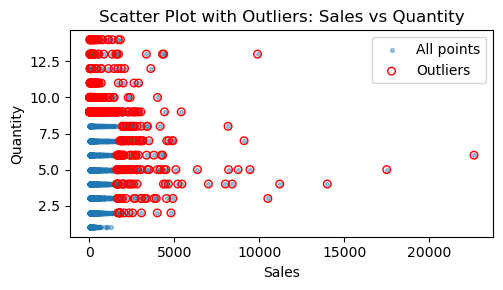

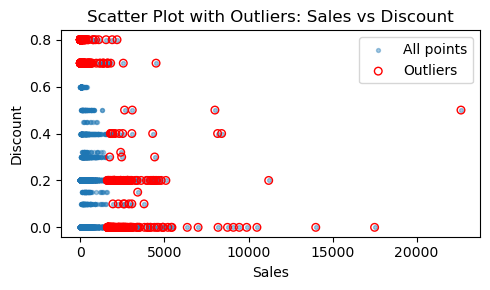

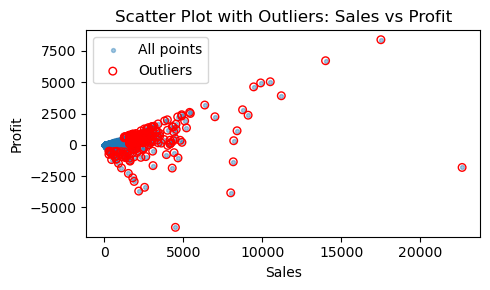

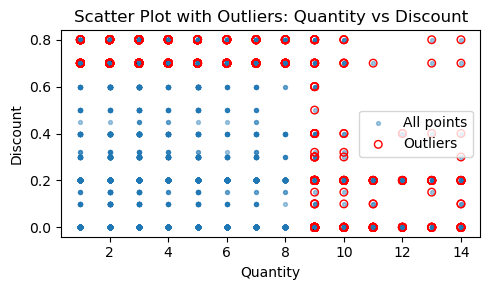

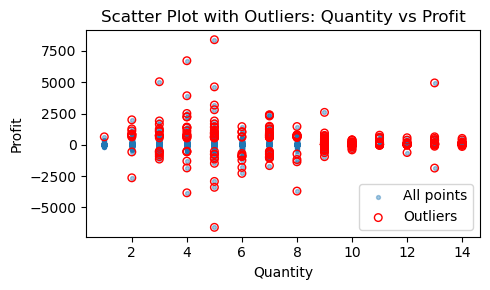

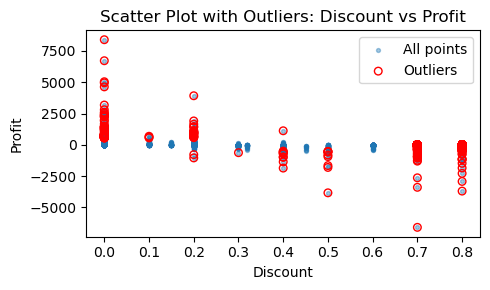

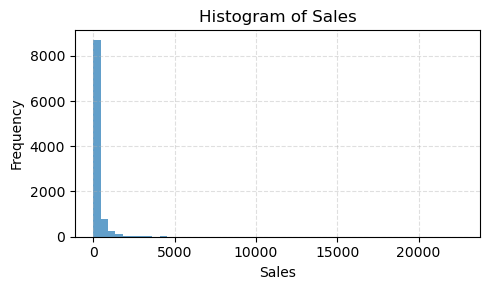

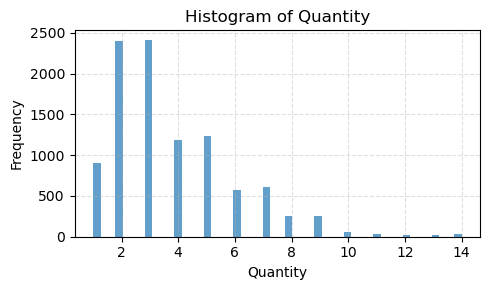

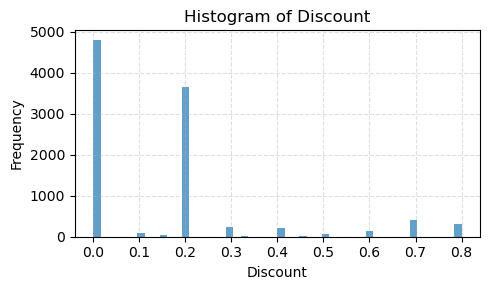

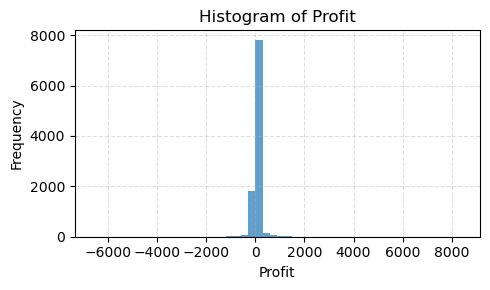

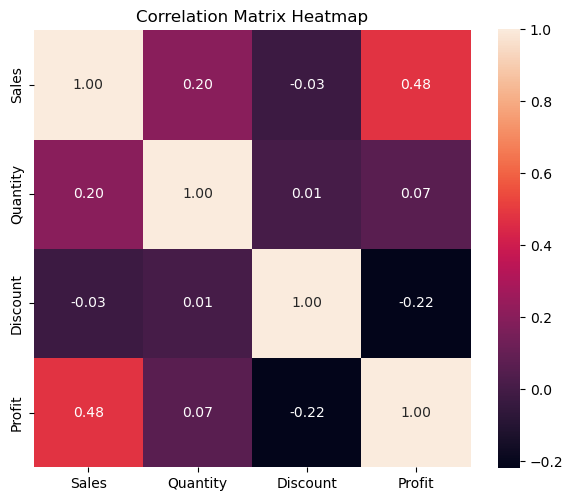

Correlation matrix:
             Sales  Quantity  Discount    Profit
Sales     1.000000  0.200795 -0.028190  0.479064
Quantity  0.200795  1.000000  0.008623  0.066253
Discount -0.028190  0.008623  1.000000 -0.219487
Profit    0.479064  0.066253 -0.219487  1.000000


In [277]:
visual_exploration_code_writer = student_a

def plot_outlier_scatter(
    data: pd.DataFrame,
    outlier_report: dict,
    columns=('Sales', 'Quantity', 'Discount', 'Profit')
):
    tmp = data.copy().reset_index(drop=True)
    num_cols = [c for c in columns if c in tmp.columns]

    outlier_indices = {
        col: set(int(e["index"]) for e in entries if isinstance(entries, list))
        for col, entries in outlier_report.items()
    }

    for i in range(len(num_cols)):
        for j in range(i + 1, len(num_cols)):
            x_col = num_cols[i]
            y_col = num_cols[j]

            plt.figure(figsize=(5, 3))
            plt.scatter(
                tmp[x_col],
                tmp[y_col],
                alpha=0.4,
                s=8,                   # <<< smaller dots
                label="All points"
            )

            # Mark outliers in either column
            idx_union = outlier_indices.get(x_col, set()) | outlier_indices.get(y_col, set())
            if idx_union:
                mask = tmp.index.isin(idx_union)
                plt.scatter(
                    tmp.loc[mask, x_col],
                    tmp.loc[mask, y_col],
                    edgecolor="red",
                    facecolor="none",
                    s=30,
                    label="Outliers"
                )

            plt.xlabel(x_col)
            plt.ylabel(y_col)
            plt.title(f"Scatter Plot with Outliers: {x_col} vs {y_col}")
            plt.legend()
            plt.tight_layout()
            plt.show()

def plot_histograms(
    data: pd.DataFrame,
    columns=('Sales', 'Quantity', 'Discount', 'Profit'),
    bins=50
):
    tmp = data.copy().reset_index(drop=True)
    existing_cols = [col for col in columns if col in tmp.columns]

    for col in existing_cols:
        plt.figure(figsize=(5, 3))
        plt.hist(tmp[col].astype(float), bins=bins, alpha=0.7)
        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()


def plot_correlation_matrix(data: pd.DataFrame, columns=('Sales', 'Quantity', 'Discount', 'Profit')):
    tmp = data.copy().reset_index(drop=True)
    existing_cols = [c for c in columns if c in tmp.columns]

    numeric_df = tmp[existing_cols].astype(float)
    corr_matrix = numeric_df.corr(method='pearson')

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        xticklabels=existing_cols,
        yticklabels=existing_cols,
        square=True
    )
    plt.title("Correlation Matrix Heatmap")
    plt.tight_layout()
    plt.show()

    return corr_matrix


vis_columns = ('Sales', 'Quantity', 'Discount', 'Profit')
start_time_vis = now()

plot_outlier_scatter(data, dq["outliers"], columns=vis_columns) #Use dq["outliers"] from data quality section
plot_histograms(data, columns=vis_columns, bins=50)
corr_matrix = plot_correlation_matrix(data, columns=vis_columns)

end_time_vis = now()

print("Correlation matrix:")
print(corr_matrix)

#############################################
# Documentation
#############################################

vis_ass_uuid_executor = "c2f9a6f4-60ab-4b93-9f39-4e2cfcc5a901"

visual_exploration_executor = [
    f':visual_exploration prov:qualifiedAssociation :{vis_ass_uuid_executor} .',
    f':{vis_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{vis_ass_uuid_executor} rdf:type prov:Association .',
    f':{vis_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]

engine.insert(visual_exploration_executor, prefixes=prefixes)


vis_ass_uuid_writer = "6e11f2a3-0e9a-4a65-b0c0-9c434e8b2a77"

vis_comment = """
Visual exploration of Sales, Quantity, Discount, and Profit including:
- Scatter plots highlighting outliers detected earlier
- Histograms illustrating distribution shapes
- Correlation matrix heatmap visualizing linear relationships

These visualizations support hypothesis generation and provide insight into
distribution skewness, outlier behavior, and attribute interactions as
required in the Data Understanding phase.
"""

visual_exploration_activity = [
    ':visual_exploration rdf:type prov:Activity .',
    ':visual_exploration sc:isPartOf :data_understanding_phase .',

    # human-readable description
    f':visual_exploration rdfs:comment """{vis_comment}""" .',

    # timing
    f':visual_exploration prov:startedAtTime "{start_time_vis}"^^xsd:dateTime .',
    f':visual_exploration prov:endedAtTime "{end_time_vis}"^^xsd:dateTime .',

    # writer association (provenance)
    f':visual_exploration prov:qualifiedAssociation :{vis_ass_uuid_writer} .',
    f':{vis_ass_uuid_writer} prov:agent :{visual_exploration_code_writer} .',
    f':{vis_ass_uuid_writer} rdf:type prov:Association .',
    f':{vis_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # inputs used for visualization
    ':visual_exploration prov:used :data .',
    ':visual_exploration prov:used :data_quality_report .',

    # output entity
    ':visual_exploration_report rdf:type prov:Entity .',
    ':visual_exploration_report sc:isPartOf :data_understanding_phase .',
    ':visual_exploration_report prov:wasGeneratedBy :visual_exploration .',
    f':visual_exploration_report rdfs:comment """Visual exploration figures were generated and interpreted.""" .',
]

engine.insert(visual_exploration_activity, prefixes=prefixes)


**e. Evaluate and document whether the data set contains attributes that are potentially ethically sensitive, minority classes or underrepresented data groups, unbalanced distributions with respect to bias (to guide over- and under-sampling, micro- and macro evaluation criteria).**

In [278]:
#############################################
# Documentation
#############################################

du_ethics_comment = """
The Superstore dataset does not contain direct sensitive personal information 
such as race, gender, age, income, or health data. However, several attributes 
can indirectly reflect demographic or socioeconomic structures:

- 'Region', 'State', and 'City' may reflect geographic disparities in access to 
  goods and logistics performance.
- 'Segment' may represent customer types with inherently different spending 
  power (Home Office, Corporate, Consumer), which implies potential 
  representation imbalance among customer groups.
- Some regions appear less represented in the data, implying potential 
  underrepresentation of certain geographical markets.
- Uneven distributions in order frequency across customer segments may create 
  implicit model bias if predictions consistently favor the most represented group.
"""

du_ethics = [
    ':du_ethics rdf:type prov:Entity .',
    ':du_ethics sc:isPartOf :data_understanding_phase .',
    f':du_ethics rdfs:comment """{du_ethics_comment}""" .',
]

engine.insert(du_ethics, prefixes=prefixes)


**f. What potential risks and additional types of bias exist in the data? What questions would you need to have answered by an external expert in order to determine potential bias or data quality issues?**

In [279]:
#############################################
# Documentation
#############################################

du_bias_risks_comment = """
Potential risks and additional bias sources in the dataset include:

1. Geographic Bias:
   Certain states and regions appear significantly over- or underrepresented.
   This imbalance could distort model behavior, making predictions overly tuned 
   to high-frequency regions.

2. Customer Segment Bias:
   Customer segments are not evenly distributed, which may bias predictions 
   toward the majority class (e.g., Consumer segment).

3. Pricing and Discount Bias:
   Discount values vary between product categories. A model may incorrectly 
   treat discount-heavy categories as inherently lower-value, introducing 
   operational bias.

4. Profit and Sales Distribution Skew:
   Strong right skewness in 'Sales' and 'Profit' may cause models to overweight 
   high-value transactions while under-representing low-volume customers.

Questions requiring expert clarification:
- Are regional sales volumes reflective of real market size, or are they 
  sampling artifacts?
- Are discounts systematically applied to specific categories or customer groups?
- Should low-profit or highly discounted transactions be treated differently 
  in forecasting and evaluation?
- Are there external economic, seasonal, or promotional factors not represented 
  in this dataset that systematically affect certain groups?

"""

du_bias_risks = [
    ':du_bias_risks rdf:type prov:Entity .',
    ':du_bias_risks sc:isPartOf :data_understanding_phase .',
    f':du_bias_risks rdfs:comment """{du_bias_risks_comment}""" .',
]

engine.insert(du_bias_risks, prefixes=prefixes)


**g. Which actions are likely required in data preparation based on this analysis?**

In [280]:
#############################################
# Documentation
#############################################

du_prep_actions_comment = """
Based on the findings from the Data Understanding phase, the following data 
preparation actions are recommended:

1. Outlier Handling:
   Extreme values in Sales, Profit, and Discount can distort model behavior and 
   disproportionately influence error metrics. These will be handled through 
   removal or capping depending on severity. In addition, Sales will undergo a 
   log transformation to reduce heteroscedasticity, compress extreme values, 
   and improve model stability.

2. Missing Value Treatment:
   The completeness analysis confirmed that the dataset contains 0% missing values 
   across all attributes (identifiers, dates, geographic descriptors, product 
   fields, and numeric measures). Because no missingness is present, no imputation 
   strategies are required.

3. Duplicate Treatment:
   Duplicate records were detected based on the business key (Order ID, Product ID). 
   In all duplicate pairs, every attribute except Row ID, Sales, Quantity, and 
   Profit is identical. This pattern strongly suggests that the customer modified 
   an order line while retaining all categorical and descriptive fields. To avoid 
   double counting and to preserve only the most recent version of each order, 
   the first occurrence of each duplicate pair will be removed, and the later 
   (updated) record will be retained.

4. Feature Engineering:
   Derive informative temporal features (e.g., day of week, month, year) from the 
   Order Date to capture seasonal or cyclical purchasing patterns.

5. Skewness Consideration:
   The Sales distribution is highly right-skewed, with most transactions near 
   zero and a long tail of high-value orders. Such skewness can degrade regression 
   performance by over-emphasizing rare extreme cases. A log transformation will 
   therefore be applied to Sales. Other skewed attributes (e.g., Profit) will not 
   be transformed, as the downstream CatBoost model is robust to non-normal 
   feature distributions and does not rely on scale-sensitive assumptions.

6. Categorical Encoding:
   Segment, Region, Category, and Sub-Category will be encoded using approaches 
   compatible with the selected modeling method (e.g., CatBoost-native categorical 
   encoding or one-hot encoding if needed). This ensures that categorical 
   attributes are appropriately represented in the model without inflating 
   dimensionality unnecessarily.

7. Plausibility and Consistency Checks:
   Additional integrity checks will ensure that:
   - Discount values fall within the expected [0, 1] range,
   - Postal codes follow valid formats,
   - Sales and Quantity values are strictly positive,
   - Ship Date is chronologically after Order Date.

8. Representation and Bias Considerations:
   Several geographic and customer segments appear underrepresented. If these 
   imbalances are found to affect model fairness or accuracy, resampling, 
   reweighting, or stratified evaluation may be applied to ensure that model 
   performance is not biased toward majority groups.

Overall, these preparation steps ensure that the dataset is clean, consistent, 
representative, and suitable for robust and fair predictive modeling.
"""


du_prep_actions = [
    ':du_prep_actions rdf:type prov:Entity .',
    ':du_prep_actions sc:isPartOf :data_understanding_phase .',
    f':du_prep_actions rdfs:comment """{du_prep_actions_comment}""" .',
]

engine.insert(du_prep_actions, prefixes=prefixes)


### 3. Data Preparation

In [281]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

**Handling all outliers that were identified in the Data Understanding Phase.**

In [282]:
handle_outliers_code_writer = student_b
def handle_outliers(df:pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    """
    Handle outliers according to the following strategy:
    
    Sales:    strongly right-skewed, strictly positive, heavy-tailed
              -> log-transform
    
    Quantity: skewed, discrete integers, usually small, with rare extreme values
              bulk orders no errors, but can heavily influence regression
              dropping removes important customer behavior, log-transform distorts the semantics
              -> cap extreme values but preserve all entries
    
    Discount: high values reflect real promotions, not errors
              naturally capped at 1
              -> keep entries
    
    Profit:   highly skewed, valid extreme gains/losses
              negative values prevent log-transform, but extremes distort modeling
              -> cap extreme values but preserve all entries
    """
    df_no_outlier = df.copy()
    
    # Extract the collected outlier indices per column
    outlier_indices = {
        col: [entry["index"] for entry in entries]
        for col, entries in outliers_report.items()
    }
    
    # Sales
    if not (df["Sales"] > 0).all():
        raise ValueError("Invalid data detected: some Sales values are not positive in the Data Preparation phase.")
    df_no_outlier["Sales_log"] = np.log(df_no_outlier["Sales"])
    
    # Quantity
    if "Quantity" in outlier_indices:
        q_high = df_no_outlier["Quantity"].quantile(0.99)
        rows = outlier_indices["Quantity"]
        df_no_outlier.loc[rows, "Quantity"] = df_no_outlier.loc[rows, "Quantity"].clip(upper=q_high)
    
    # Profit
    if "Profit" in outlier_indices:
        p_low = df_no_outlier["Profit"].quantile(0.005)
        p_high = df_no_outlier["Profit"].quantile(0.995)
        rows = outlier_indices["Profit"]
        df_no_outlier.loc[rows, "Profit"] = df_no_outlier.loc[rows, "Profit"].clip(lower=p_low, upper=p_high)

    return df_no_outlier

start_time_td = now()
no_outlier_data = handle_outliers(data, dq["outliers"])
end_time_td = now()

display(no_outlier_data)

#############################################
# Documentation
#############################################

ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
td_comment = """
Handling all outliers that were identified in the Data Understanding Phase.
The following approach was used for each column represented in the outlier summary:
- Sales: strongly right-skewed, strictly positive, heavy-tailed -> apply log-transform (new column: Sales_log)
- Quantity: discrete, skewed with rare bulk orders -> cap only detected outlier rows using the 99th percentile as upper bound (preserve all entries)
- Discount: high values reflect valid promotions and are naturally capped at 1 -> keep all entries unchanged
- Profit: highly skewed with valid extreme gains/losses -> cap only detected outlier rows using the 0.5th percentile as lower bound and the 99.5th percentile as upper bound
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :data_qaulity_report .',
    ':no_outlier_data rdf:type prov:Entity .',
    ':no_outlier_data prov:wasGeneratedBy :handle_outliers .',
    ':no_outlier_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Sales_log
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,5.568192
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,6.595699
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2.682390
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,6.864407
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,3.107631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2014-110422,2014-01-21,2014-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028,3.228747
9990,9991,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332,4.521354
9991,9992,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932,5.555190
9992,9993,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200,3.387774


**Missing Value Treatment in the Data Preparation phase.**

In [283]:
handle_missing_values_code_writer = student_b
def handle_missing_values(df:pd.DataFrame) -> pd.DataFrame:
    """
    Confirm that the dataset contains no missing values after outlier handling.
    This step implements the Data Preparation decision:
    - In the Data Understanding phase no missing values were observed
    - Therefore, no imputation, row/column deletion, or other modifications are applied
    - This activity verifies that there are still no missing values after previous
      preparation steps
    """
    mv_counts = df.isna().sum()
    if not (mv_counts == 0).all():
        raise ValueError("Unexpected missing values found in Data Preparation phase.")
    
    return df

start_time_mv = now()
no_missing_data = handle_missing_values(no_outlier_data)
end_time_mv = now()

display(no_missing_data.head())

#############################################
# Documentation
#############################################

mv_ass_uuid_executor = "4239ba2c-d9c6-4e74-970f-fa60ddb63c2b"
handle_missing_values_executor = [
    f':handle_missing_values prov:qualifiedAssociation :{mv_ass_uuid_executor} .',
    f':{mv_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{mv_ass_uuid_executor} rdf:type prov:Association .',
    f':{mv_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_missing_values_executor, prefixes=prefixes)

mv_ass_uuid_writer = "b97d9261-421c-447a-a7d6-50a90f4f8714"
mv_comment = """
Missing Value Treatment in the Data Preparation phase.
In the Data Understanding phase no missing values were observed.
Therefore, no imputation, row/column deletion, or other modifications are applied.
This activity verifies that there are still no missing values after previous preparation steps.
"""

handle_missing_values_activity = [
    ':handle_missing_values rdf:type prov:Activity .',
    ':handle_missing_values sc:isPartOf :data_preparation_phase .',
    ':handle_missing_values rdfs:comment \'Data Preparation\' .',
    f':handle_missing_values rdfs:comment """{mv_comment}""" .',
    f':handle_missing_values prov:startedAtTime "{start_time_mv}"^^xsd:dateTime .',
    f':handle_missing_values prov:endedAtTime "{end_time_mv}"^^xsd:dateTime .',
    f':handle_missing_values prov:qualifiedAssociation :{mv_ass_uuid_writer} .',
    f':{mv_ass_uuid_writer} prov:agent :{handle_missing_values_code_writer} .',
    f':{mv_ass_uuid_writer} rdf:type prov:Association .',
    f':{mv_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_missing_values prov:used :no_outlier_data .',
    ':no_missing_data rdf:type prov:Entity .',
    ':no_missing_data prov:wasGeneratedBy :handle_missing_values .',
    ':no_missing_data prov:wasDerivedFrom :no_outlier_data .',
]
engine.insert(handle_missing_values_activity, prefixes=prefixes)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Sales_log
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,5.568192
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,6.595699
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2.682390
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,6.864407
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,3.107631


**Duplicate Treatment in the Data Preparation phase.**

In [284]:
duplicate_treatment_code_writer = student_b
def handle_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Handle duplicate records in the dataset according to the following logic:

    - Duplicates are defined by identical (Order ID, Product ID) pairs.
    - In the Data Understanding phase we assumed that this is because orders were edited or updated
    - The assumption is that the later record represents the corrected or final version of the order
    - Therefore, earlier occurrences are removed and only the most recent occurrence is retained

    No new duplicates can exist because previous steps in the Data preparation phase did not modify the key attributes "Order ID" and "Product ID".
    """
    df_copy = df.copy()
    
    # Keep the last (updated) version of each duplicate order line
    df_no_duplicate = df_copy.drop_duplicates(
        subset=["Order ID", "Product ID"],
        keep="last"
    )
    return df_no_duplicate


start_time_dup = now()
no_duplicate_data = handle_duplicates(no_missing_data)
end_time_dup = now()

display(no_duplicate_data.head())

#############################################
# Documentation
#############################################

dup_ass_uuid_executor = "e34b95af-3cf8-4ba6-ad43-bfe17ceed1d8"
handle_duplicates_executor = [
    f':handle_duplicates prov:qualifiedAssociation :{dup_ass_uuid_executor} .',
    f':{dup_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dup_ass_uuid_executor} rdf:type prov:Association .',
    f':{dup_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_duplicates_executor, prefixes=prefixes)

dup_ass_uuid_writer = "d8694288-7fd7-42af-85f4-a5035747d350"

dup_comment = """
Duplicate Treatment in the Data Preparation phase.
Duplicates are defined by identical (Order ID, Product ID) pairs.
In the Data Understanding phase we assumed that this is because orders were edited or updated.
The assumption is that the later record represents the corrected or final version of the order.
Therefore, earlier occurrences are removed and only the most recent occurrence is retained.
No new duplicates can exist because previous steps in the Data preparation phase did not modify the key attributes "Order ID" and "Product ID".
"""

handle_duplicates_activity = [
    ':handle_duplicates rdf:type prov:Activity .',
    ':handle_duplicates sc:isPartOf :data_preparation_phase .',
    ':handle_duplicates rdfs:comment \'Data Preparation\' .',
    f':handle_duplicates rdfs:comment """{dup_comment}""" .',
    f':handle_duplicates prov:startedAtTime "{start_time_dup}"^^xsd:dateTime .',
    f':handle_duplicates prov:endedAtTime "{end_time_dup}"^^xsd:dateTime .',
    f':handle_duplicates prov:qualifiedAssociation :{dup_ass_uuid_writer} .',
    f':{dup_ass_uuid_writer} prov:agent :{duplicate_treatment_code_writer} .',
    f':{dup_ass_uuid_writer} rdf:type prov:Association .',
    f':{dup_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_duplicates prov:used :no_missing_data .',
    ':no_duplicate_data rdf:type prov:Entity .',
    ':no_duplicate_data prov:wasGeneratedBy :handle_duplicates .',
    ':no_duplicate_data prov:wasDerivedFrom :no_missing_data .',
]
engine.insert(handle_duplicates_activity, prefixes=prefixes)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Sales_log
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,5.568192
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,6.595699
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2.682390
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,6.864407
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,3.107631


**Analyze options and potential for derived attributes: Feature Engineering.**

In [285]:
feature_engineering_code_writer = student_b
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Derive temporal features from Order Date:
    - order_year
    - order_month
    - order_weekofyear
    - order_dayofweek
    - order_dayofmonth

    These features describe when the order was placed and help represent seasonal patterns, monthly trends and weekly cycles.
    """
    df_feat = df.copy()

    df_feat["order_year"]       = df_feat["Order Date"].dt.year
    df_feat["order_month"]      = df_feat["Order Date"].dt.month
    df_feat["order_weekofyear"] = df_feat["Order Date"].dt.isocalendar().week.astype(int)
    df_feat["order_dayofweek"]  = df_feat["Order Date"].dt.dayofweek
    df_feat["order_dayofmonth"] = df_feat["Order Date"].dt.day

    return df_feat

start_time_fe = now()
engineered_data = engineer_features(no_duplicate_data)
end_time_fe = now()

display(engineered_data.head())

#############################################
# Documentation
#############################################

fe_ass_uuid_executor = "c3f19b23-aa7f-4425-ad36-67d2b5d2b35b"
feature_engineering_executor = [
    f':engineer_features prov:qualifiedAssociation :{fe_ass_uuid_executor} .',
    f':{fe_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{fe_ass_uuid_executor} rdf:type prov:Association .',
    f':{fe_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(feature_engineering_executor, prefixes=prefixes)

fe_ass_uuid_writer = "332756c3-cf4e-4357-b2cf-8fe0b75e779b"
fe_comment = """
Analyze options and potential for derived attributes: Feature Engineering.
We derive temporal features from the Order Date: order_year, order_month, order_weekofyear, order_dayofweek, order_dayofmonth.
These features describe when the order was placed and help represent seasonal patterns, monthly trends and weekly cycles.
They help the ML model capture cyclic and seasonal variation.
We do not introduce data leakage since the Order Date is already known at the time the sale.
We also considered engineering interaction features, such as combining Quantity with Discount or Category with Region.
Since CatBoost automatically models such interactions for categorical and numerical variables, we did not expect a high additional benefit from adding them manually.
"""

feature_engineering_activity = [
    ':engineer_features rdf:type prov:Activity .',
    ':engineer_features sc:isPartOf :data_preparation_phase .',
    ':engineer_features rdfs:comment "Data Preparation" .',
    f':engineer_features rdfs:comment """{fe_comment}""" .',
    f':engineer_features prov:startedAtTime "{start_time_fe}"^^xsd:dateTime .',
    f':engineer_features prov:endedAtTime "{end_time_fe}"^^xsd:dateTime .',
    f':engineer_features prov:qualifiedAssociation :{fe_ass_uuid_writer} .',
    f':{fe_ass_uuid_writer} prov:agent :{feature_engineering_code_writer} .',
    f':{fe_ass_uuid_writer} rdf:type prov:Association .',
    f':{fe_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':engineer_features prov:used :no_duplicate_data .',
    ':engineered_data rdf:type prov:Entity .',
    ':engineered_data prov:wasGeneratedBy :engineer_features .',
    ':engineered_data prov:wasDerivedFrom :no_duplicate_data .',
]

engine.insert(feature_engineering_activity, prefixes=prefixes)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sales,Quantity,Discount,Profit,Sales_log,order_year,order_month,order_weekofyear,order_dayofweek,order_dayofmonth
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,261.9600,2,0.00,41.9136,5.568192,2016,11,45,1,8
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,731.9400,3,0.00,219.5820,6.595699,2016,11,45,1,8
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,14.6200,2,0.00,6.8714,2.682390,2016,6,23,6,12
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,957.5775,5,0.45,-383.0310,6.864407,2015,10,41,6,11
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,22.3680,2,0.20,2.5164,3.107631,2015,10,41,6,11


**Categorical Encoding Verification.**

In [286]:
categorical_encoding_code_writer = student_b
def verify_categorical_types(df: pd.DataFrame, categorical_cols: list) -> pd.DataFrame:
    """
    Verify that the four main categorical modeling features are stored as
    strings/object dtype so CatBoost can apply its internal ordered target encoding.
    According to the CatBoost documentation, it can automatically handle categorical features
    and does not require one-hot encoding. Categorical values should be provided as strings or pandas 'object' dtype.
    Since CatBoost performs its own encoding, no manual encoding is applied in the Data Preparation phase.
    """
    for col in categorical_cols:
        if df[col].dtype not in ["object", "category"]:
            raise TypeError(
                "Column '" + col + "' must be of dtype object/category for CatBoost automatic categorical encoding."
            )
    return df

# primary categorical modeling features from Data Understanding phase
categorical_features = [
    "Segment",
    "Region",
    "Category",
    "Sub-Category"
]

start_time_ce = now()
categorical_data = verify_categorical_types(engineered_data, categorical_features)
end_time_ce = now()

display(categorical_data.head())

#############################################
# Documentation
#############################################

ce_ass_uuid_executor = "5ad74ad6-16f8-483a-bcfa-2ea061e9c5f1"
categorical_encoding_executor = [
    f':verify_categorical_types prov:qualifiedAssociation :{ce_ass_uuid_executor} .',
    f':{ce_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ce_ass_uuid_executor} rdf:type prov:Association .',
    f':{ce_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(categorical_encoding_executor, prefixes=prefixes)

ce_ass_uuid_writer = "04a5a8b5-b020-4034-b2e2-7dd50d358426"
ce_comment = """
Categorical Encoding Verification.
We verify that the four main categorical modeling features are stored as strings/object dtype so CatBoost can apply its internal ordered target encoding.
According to the CatBoost documentation, it can automatically handle categorical features and does not require one-hot encoding.
Categorical values should be provided as strings or pandas 'object' dtype.
Since CatBoost performs its own encoding, no manual encoding is applied in the Data Preparation phase.
This activity checks that the primary categorical modeling features (Segment, Region, Category, Sub-Category) are correctly stored, ensuring CatBoost can process them without one-hot encoding.
"""
categorical_encoding_activity = [
    ':verify_categorical_types rdf:type prov:Activity .',
    ':verify_categorical_types sc:isPartOf :data_preparation_phase .',
    ':verify_categorical_types rdfs:comment "Data Preparation" .',
    f':verify_categorical_types rdfs:comment """{ce_comment}""" .',
    f':verify_categorical_types prov:startedAtTime "{start_time_ce}"^^xsd:dateTime .',
    f':verify_categorical_types prov:endedAtTime "{end_time_ce}"^^xsd:dateTime .',
    f':verify_categorical_types prov:qualifiedAssociation :{ce_ass_uuid_writer} .',
    f':{ce_ass_uuid_writer} prov:agent :{categorical_encoding_code_writer} .',
    f':{ce_ass_uuid_writer} rdf:type prov:Association .',
    f':{ce_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':verify_categorical_types prov:used :engineered_data .',
    ':categorical_data rdf:type prov:Entity .',
    ':categorical_data prov:wasGeneratedBy :verify_categorical_types .',
    ':categorical_data prov:wasDerivedFrom :engineered_data .',
]
engine.insert(categorical_encoding_activity, prefixes=prefixes)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sales,Quantity,Discount,Profit,Sales_log,order_year,order_month,order_weekofyear,order_dayofweek,order_dayofmonth
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,261.9600,2,0.00,41.9136,5.568192,2016,11,45,1,8
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,731.9400,3,0.00,219.5820,6.595699,2016,11,45,1,8
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,14.6200,2,0.00,6.8714,2.682390,2016,6,23,6,12
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,957.5775,5,0.45,-383.0310,6.864407,2015,10,41,6,11
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,22.3680,2,0.20,2.5164,3.107631,2015,10,41,6,11


**Plausibility and consistency checks were applied to validate the integrity of the prepared dataset.**

In [287]:
plausibility_code_writer = student_b
def check_plausibility_and_consistency(df: pd.DataFrame) -> pd.DataFrame:
    """
    Plausibility and consistency checks for the prepared data.
    This function enforces the following rules:
    1) Sales must be strictly positive.
    2) Quantity must be strictly positive.
    3) Discount values must lie within [0, 1].
    4) Ship Date must be on or after Order Date.
    5) If all rows belong to the United States, Postal Code must be a positive
       4–5 digit value (integer ZIP code with possible loss of leading zeros).
       
    The function raises a ValueError if any violation is found and otherwise
    returns the input DataFrame unchanged.
    """
    df_check = df.copy()

    # 1) Sales strictly positive
    if (df_check["Sales"] <= 0).any():
        raise ValueError("Plausibility check failed: Sales must be strictly positive.")

    # 2) Quantity must be strictly positive
    if (df_check["Quantity"] <= 0).any():
        raise ValueError("Plausibility check failed: Quantity must be strictly positive.")

    # 3) Discount in [0, 1]
    invalid_discount_mask = (df_check["Discount"] < 0) | (df_check["Discount"] > 1)
    if invalid_discount_mask.any():
        raise ValueError("Plausibility check failed: Discount values must be in [0, 1].")

    # 4) Ship Date >= Order Date
    invalid_date_mask = df_check["Ship Date"] < df_check["Order Date"]
    if invalid_date_mask.any():
        raise ValueError(
            "Consistency check failed: Ship Date must be greater than or equal to Order Date."
        )

    # 5) Postal Code plausibility (only if all rows are US)
    countries = df_check["Country"].unique()
    if len(countries) == 1 and countries[0] == "United States":
        postal_str = df_check["Postal Code"].astype(str)
        valid_length = postal_str.str.len().isin([4, 5])
        valid_positive = df_check["Postal Code"] > 0
        valid_zip = valid_length & valid_positive

        if (~valid_zip).any():
            raise ValueError(
                "Consistency check failed: Postal Code values do not follow expected US ZIP rules."
            )

    return df_check

start_time_pc = now()
consistent_data = check_plausibility_and_consistency(categorical_data)
end_time_pc = now()

display(consistent_data.head())

#############################################
# Documentation
#############################################

pc_ass_uuid_executor = "929e9112-3b38-49f3-a4ea-24448a21149e"
plausibility_check_executor = [
    f':check_plausibility_and_consistency prov:qualifiedAssociation :{pc_ass_uuid_executor} .',
    f':{pc_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{pc_ass_uuid_executor} rdf:type prov:Association .',
    f':{pc_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(plausibility_check_executor, prefixes=prefixes)

pc_ass_uuid_writer = "0c32fee7-6295-431e-b790-6bba003f3c09"

pc_comment = """
Plausibility and consistency checks were applied to validate the integrity of the prepared dataset.
These checks ensure that no logically invalid or inconsistent records remain in the dataset.
The following rules were enforced:
1) Sales must be strictly positive.
2) Quantity must be strictly positive.
3) Discount values must lie within [0, 1].
4) Ship Date must be on or after Order Date.
5) If all rows belong to the United States, Postal Code must be a positive 4–5 digit value (integer ZIP code with possible loss of leading zeros).
"""

plausibility_check_activity = [
    ':check_plausibility_and_consistency rdf:type prov:Activity .',
    ':check_plausibility_and_consistency sc:isPartOf :data_preparation_phase .',
    ':check_plausibility_and_consistency rdfs:comment "Data Preparation" .',
    f':check_plausibility_and_consistency rdfs:comment """{pc_comment}""" .',
    f':check_plausibility_and_consistency prov:startedAtTime "{start_time_pc}"^^xsd:dateTime .',
    f':check_plausibility_and_consistency prov:endedAtTime "{end_time_pc}"^^xsd:dateTime .',
    f':check_plausibility_and_consistency prov:qualifiedAssociation :{pc_ass_uuid_writer} .',
    f':{pc_ass_uuid_writer} prov:agent :{plausibility_code_writer} .',
    f':{pc_ass_uuid_writer} rdf:type prov:Association .',
    f':{pc_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_plausibility_and_consistency prov:used :categorical_data .',
    ':consistent_data rdf:type prov:Entity .',
    ':consistent_data prov:wasGeneratedBy :check_plausibility_and_consistency .',
    ':consistent_data prov:wasDerivedFrom :categorical_data .',
]
engine.insert(plausibility_check_activity, prefixes=prefixes)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sales,Quantity,Discount,Profit,Sales_log,order_year,order_month,order_weekofyear,order_dayofweek,order_dayofmonth
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,261.9600,2,0.00,41.9136,5.568192,2016,11,45,1,8
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,731.9400,3,0.00,219.5820,6.595699,2016,11,45,1,8
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,14.6200,2,0.00,6.8714,2.682390,2016,6,23,6,12
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,957.5775,5,0.45,-383.0310,6.864407,2015,10,41,6,11
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,22.3680,2,0.20,2.5164,3.107631,2015,10,41,6,11


**Representation and bias analysis for key categorical attributes.**

In [288]:
representation_code_writer = student_b
def analyze_category_balance(df: pd.DataFrame, categorical_cols: list) -> dict:
    """
    Summarize class balance for key categorical attributes.
    For each column in categorical_cols this function computes:
    - "Segment", "Region", "Category":
        * absolute counts per attributes (global)
        * relative frequency in percent over the full dataset
    - "Sub-Category":
        * counts of "Sub-Category" within each "Category"
        * relative frequency in percent within each "Category"
    Returns a nested dictionary with these summaries.
    """
    results = {}

    for col in categorical_cols:
        # "Segment", "Region", "Category"
        if col != "Sub-Category":
            value_counts = df[col].value_counts()
            rel_freq = value_counts / len(df) * 100.0

            summary_df = pd.DataFrame({
                "count": value_counts,
                "percentage": rel_freq.round(2)
            })

            results[col] = summary_df
            
        # "Sub-Category"
        else:
            # counts: rows = Category, columns = Sub-Category
            counts = (
                df.groupby("Category")["Sub-Category"]
                  .value_counts()
                  .unstack(fill_value=0)
            )

            # within-category percentages
            percentages = counts.div(counts.sum(axis=1), axis=0) * 100.0
            percentages = percentages.round(2)

            results["Sub-Category"] = {
                "counts": counts,
                "within_category_percentage": percentages
            }

    return results

# key categorical attributes
key_categorical_attributes = [
    "Segment",
    "Region",
    "Category",
    "Sub-Category",
]

start_time_repr = now()
representation_report = analyze_category_balance(consistent_data, key_categorical_attributes)
end_time_repr = now()

# build and print representation_summary:
parts = []

# "Segment", "Region", "Category"
for col in ["Segment", "Region", "Category"]:
    if col in representation_report:
        df_col = representation_report[col]
        parts.append(f"= {col} distribution =\n{df_col.to_string()}\n")
        
# "Sub-Category"
counts = representation_report["Sub-Category"]["counts"]
pct = representation_report["Sub-Category"]["within_category_percentage"]
parts.append(f"= Sub-Category counts by Category = \n{counts.to_string()}\n")
parts.append(
    "= Sub-Category within-category percentages =\n"
    f"{pct.to_string()}\n"
)

representation_summary = (
    "=== Representation Summary ===\n\n"
    + "\n".join(parts)
)

print(representation_summary)

#############################################
# Documentation
#############################################

repr_ass_uuid_executor = "a514c2bf-1a42-48e3-8838-63d679381d33"
representation_balance_executor = [
    f':analyze_category_balance prov:qualifiedAssociation :{repr_ass_uuid_executor} .',
    f':{repr_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{repr_ass_uuid_executor} rdf:type prov:Association .',
    f':{repr_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(representation_balance_executor, prefixes=prefixes)

repr_ass_uuid_writer = "32f2aeb5-fe50-4517-80ee-b79aad9872c0"
repr_comment = """
Representation and bias analysis for key categorical attributes.
We summarize the class balance of the main categorical variables:
- "Segment", "Region", "Category":
    * absolute counts per attributes (global)
    * relative frequency in percent over the full dataset
- "Sub-Category":
    * counts of "Sub-Category" within each "Category"
    * relative frequency in percent within each "Category"

Findings:
- Segment, Region and Category show no severely underrepresented classes.
  their groups have reasonable frequencies relative to the full dataset,
  so no resampling or reweighting has to be applied at this stage.
- For Sub-Category, the distribution is inspected within each Category.
  Some Sub-Categories occur much less frequently than others inside the
  same Category (some < 5% of entries in that Category) and are
  therefore flagged as potentially underrepresented. Resampling or
  reweighting might lead to better results in the Modeling phase.
"""
representation_balance_activity = [
    ':analyze_category_balance rdf:type prov:Activity .',
    ':analyze_category_balance sc:isPartOf :data_preparation_phase .',
    ':analyze_category_balance rdfs:comment "Data Preparation" .',
    f':analyze_category_balance rdfs:comment """{repr_comment}""" .',
    f':analyze_category_balance prov:startedAtTime "{start_time_repr}"^^xsd:dateTime .',
    f':analyze_category_balance prov:endedAtTime "{end_time_repr}"^^xsd:dateTime .',
    f':analyze_category_balance prov:qualifiedAssociation :{repr_ass_uuid_writer} .',
    f':{repr_ass_uuid_writer} prov:agent :{representation_code_writer} .',
    f':{repr_ass_uuid_writer} rdf:type prov:Association .',
    f':{repr_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':analyze_category_balance prov:used :consistent_data .',
    ':representation_report rdf:type prov:Entity .',
    ':representation_report prov:wasGeneratedBy :analyze_category_balance .',
    ':representation_report prov:wasDerivedFrom :consistent_data .',
    f':representation_report rdfs:comment """{representation_summary}""" .',
]
engine.insert(representation_balance_activity, prefixes=prefixes)

=== Representation Summary ===

= Segment distribution =
             count  percentage
Segment                       
Consumer      5189       51.96
Corporate     3019       30.23
Home Office   1778       17.80

= Region distribution =
         count  percentage
Region                    
West      3202       32.06
East      2845       28.49
Central   2323       23.26
South     1616       16.18

= Category distribution =
                 count  percentage
Category                          
Office Supplies   6022       60.30
Furniture         2119       21.22
Technology        1845       18.48

= Sub-Category counts by Category = 
Sub-Category     Accessories  Appliances  Art  Binders  Bookcases  Chairs  Copiers  Envelopes  Fasteners  Furnishings  Labels  Machines  Paper  Phones  Storage  Supplies  Tables
Category                                                                                                                                                                         
Furni

**Attribute Removal in the Data Preparation phase.**

In [289]:
attr_removal_executor = student_b
def remove_attributes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove attributes that cause data leakage or provide no predictive value for Sales prediction:
    - Profit (derived from Sales -> leakage)
    - Ship Date (only known after sale -> leakage)
    - Row ID, Order ID (pure identifiers)
    - Country (only removed if the dataset contains exactly one unique value)
    Returns: pd.DataFrame without the removed columns
    """
    df_removed = df.copy()

    cols_remove = ["Profit", "Ship Date", "Row ID", "Order ID"]
    
    if df_removed["Country"].nunique() == 1:
        cols_remove.append("Country")

    df_removed.drop(columns=cols_remove, errors="ignore", inplace=True)

    return df_removed

start_time_attr_removal = now()
removed_attributes_data = remove_attributes(consistent_data)
end_time_attr_removal = now()

display(removed_attributes_data)

#############################################
# Documentation
#############################################

ra_ass_uuid_executor = "ea4cb861-531e-4f08-961f-bd23701b4abb"
remove_attributes_executor = [
    f':remove_attributes prov:qualifiedAssociation :{ra_ass_uuid_executor} .',
    f':{ra_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ra_ass_uuid_executor} rdf:type prov:Association .',
    f':{ra_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(remove_attributes_executor, prefixes=prefixes)

ra_ass_uuid_writer = "dded4f67-ed3e-428e-abbd-05e5f5a69897"
ra_comment = """
Remove attributes that cause data leakage or provide no predictive value for Sales prediction:
- Profit (derived from Sales -> leakage)
- Ship Date (only known after sale -> leakage)
- Row ID, Order ID (pure identifiers)
- Country (only removed if the dataset contains exactly one unique value)
This step ensures a leakage-free and business-meaningful feature space for subsequent modeling.
"""
remove_attributes_activity = [
    ':remove_attributes rdf:type prov:Activity .',
    ':remove_attributes sc:isPartOf :data_preparation_phase .',
    ':remove_attributes rdfs:comment \'Data Preparation\' .',
    f':remove_attributes rdfs:comment """{ra_comment}""" .',
    f':remove_attributes prov:startedAtTime "{start_time_attr_removal}"^^xsd:dateTime .',
    f':remove_attributes prov:endedAtTime "{end_time_attr_removal}"^^xsd:dateTime .',
    f':remove_attributes prov:qualifiedAssociation :{ra_ass_uuid_writer} .',
    f':{ra_ass_uuid_writer} prov:agent :{attr_removal_executor} .',
    f':{ra_ass_uuid_writer} rdf:type prov:Association .',
    f':{ra_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':remove_attributes prov:used :consistent_data .',
    ':removed_attributes_data rdf:type prov:Entity .',
    ':removed_attributes_data prov:wasGeneratedBy :remove_attributes .',
    ':removed_attributes_data prov:wasDerivedFrom :consistent_data .',
]
engine.insert(remove_attributes_activity, prefixes=prefixes)

,Order Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Postal Code,Region,Product ID,...,Product Name,Sales,Quantity,Discount,Sales_log,order_year,order_month,order_weekofyear,order_dayofweek,order_dayofmonth
0,2016-11-08,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,42420,South,FUR-BO-10001798,...,Bush Somerset Collection Bookcase,261.9600,2,0.00,5.568192,2016,11,45,1,8
1,2016-11-08,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,42420,South,FUR-CH-10000454,...,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,6.595699,2016,11,45,1,8
2,2016-06-12,Second Class,DV-13045,Darrin Van Huff,Corporate,Los Angeles,California,90036,West,OFF-LA-10000240,...,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,2.682390,2016,6,23,6,12
3,2015-10-11,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,...,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,6.864407,2015,10,41,6,11
4,2015-10-11,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,...,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,3.107631,2015,10,41,6,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,2014-01-21,Second Class,TB-21400,Tom Boeckenhauer,Consumer,Miami,Florida,33180,South,FUR-FU-10001889,...,Ultra Door Pull Handle,25.2480,3,0.20,3.228747,2014,1,4,1,21
9990,2017-02-26,Standard Class,DB-13060,Dave Brooks,Consumer,Costa Mesa,California,92627,West,FUR-FU-10000747,...,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,4.521354,2017,2,8,6,26
9991,2017-02-26,Standard Class,DB-13060,Dave Brooks,Consumer,Costa Mesa,California,92627,West,TEC-PH-10003645,...,Aastra 57i VoIP phone,258.5760,2,0.20,5.555190,2017,2,8,6,26
9992,2017-02-26,Standard Class,DB-13060,Dave Brooks,Consumer,Costa Mesa,California,92627,West,OFF-PA-10004041,...,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,3.387774,2017,2,8,6,26


**Pre-processing steps considered but not applied**

In [290]:
#############################################
# Documentation
#############################################

dp_prepro_comment = """
Additional preprocessing steps were considered but not applied, as they did not
provide benefits for our goals considering the fact that CatBoost will be used for the Modeling phase:
- No scaling: CatBoost is tree-based and insensitive to feature scale.
- No binning of numeric variables: binning has a risk of reducing information because CatBoost 
  handles continuous features natively anyways.
- No additional encoding of categorical attributes: CatBoost supports raw 
  categorical variables without manual transformations.
- No further handling of skewed numeric variables: although Sales was log-
  transformed, remaining skew does not negatively impact CatBoost models.

These steps were reviewed but intentionally left out to avoid unnecessary 
transformations and to preserve the interpretability of the original features.
"""

dp_prepro = [
    ':data_considered_preprocessing rdf:type prov:Entity .',
    ':data_considered_preprocessing sc:isPartOf :data_preparation_phase .',
    f':data_considered_preprocessing rdfs:comment """{dp_prepro_comment}""" .',
]

engine.insert(dp_prepro, prefixes=prefixes)

**Consideration of potential external data sources.**

In [291]:
#############################################
# Documentation
#############################################

dp_external_comment = """
Consideration of potential external data sources.

During the Data Preparation phase we analyzed which additional external datasets could
improve the predictive performance of our model. Examples of such sources include:

- Macroeconomic indicators (inflation, consumer behaviour, GDP trends, etc.)
- Calendar-related data (public holidays, black friday, etc.)
- Competitor price or market trend
- Marketing campaign schedules or promotion data

The sources were only considered conceptually at this stage. They are not used in any 
way during the preparation of this dataset. But we see a potential that they could improve
future versions of the model.
"""

dp_external = [
    ':external_data_considered rdf:type prov:Entity .',
    ':external_data_considered sc:isPartOf :data_preparation_phase .',
    f':external_data_considered rdfs:comment """{dp_external_comment}""" .',
]

engine.insert(dp_external, prefixes=prefixes)

In [ ]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':prepared_data rdf:type sc:Dataset .',
    # ....
]
engine.insert(prepared_data_triples, prefixes=prefixes)

## Modeling

In [ ]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [ ]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
dma_comment = """
...
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example algorithm definition
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # example implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',

    
    # you can also define your Evaluation Measures here
    
    # example evaluation 
    f':r2_score_measure rdf:type mls:EvaluationMeasure .',
    f':r2_score_measure rdfs:label "R-squared Score" .',
    f':r2_score_measure rdfs:comment "xxx" .',
    f':r2_score_measure prov:wasGeneratedBy :define_algorithm .',

    
]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [ ]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "fff582a8-c5cd-4030-978b-9f56b603167c"
hp_comment = """
...
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example parameter
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "Learning Rate" .',
    f':hp_learning_rate rdfs:comment "..." .',
    f':random_forrest_classifier_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # continue with your identified hyperparameters
    
]
engine.insert(identify_hp_activity, prefixes=prefixes)

In [ ]:
def split_data(df: pd.DataFrame):
    #do something
    return 'train_set', 'validation_set', 'test_set'

#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "fb58ae6c-9d58-44c9-ac7e-529111bdf7fc"
split_comment = """
...
"""
## Use your prepared dataset
input_dataset = ":prepared_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains xx samples" .', 

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains xx samples" .', 

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains xx samples" .', 

    
]
engine.insert(define_split_activity, prefixes=prefixes)

In [ ]:
def train_and_finetune_model(training_set, validation_set):
    # do something here

    # Try to automate as much documentation work as possible.
    # Define your training runs with their respective hyperparameter settings, etc.
    # Document each time a training run, model, its hp_settings, evaluations, ...  
    # Create performance figures/graphs

    return 'Find most suitable model'


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "21d60fe3-c9ab-4a0a-bae7-b9fe9653c755"
tafm_comment = """
...
"""

# EXAMPLE output from your training
training_run1 = "run_1" 
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"


train_model_activity = [
    # Activity 
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    ########################################
    # ONE model run - automate everything below!

    # Parameter settings
    f':{hp1_setting_run1} rdf:type mls:HyperParameterSetting .',
    f':{hp1_setting_run1} mls:specifiedBy :hp_learning_rate .',
    f':{hp1_setting_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{hp1_setting_run1} prov:wasGeneratedBy :train_and_finetune_model .',
    # add your further parameters

    # Describe your Run
    f':{training_run1} rdf:type mls:Run .',
    f':{training_run1} sc:isPartOf :train_and_finetune_model .',
    f':{training_run1} mls:realizes :random_forest_algorithm .',
    f':{training_run1} rdf:label "Training Run 1 with..." .',
    f':{training_run1} mls:executes :your_implementation .', 
    f':{training_run1} mls:hasInput :training_set .',
    f':{training_run1} mls:hasInput :validation_set .',
    f':{training_run1} mls:hasInput :{hp1_setting_run1} .',     
    # list all your used parameters here
    f':{training_run1} mls:hasOutput :{model_run1} .',
    f':{training_run1} mls:hasOutput :{eval_train_run1} .',
    f':{training_run1} mls:hasOutput :{eval_validation_run1} .',

    # Describe your Model
    f':{model_run1} rdf:type mls:Model .',
    f':{model_run1} prov:label "xxx" .',
    f':{model_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{model_run1} mlso:trainedOn :training_set .',
    f':{model_run1} mlso:hasAlgorithmType :random_forest_algorithm .',

    # Describe your evaluations
    # You can have multiple evaluations per model 
    f':{eval_train_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_train_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_train_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_train_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_train_run1} prov:used :training_set .',

    f':{eval_validation_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_validation_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_validation_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_validation_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_validation_run1} prov:used :validation_set .',

    # Dont forget to document any visualizations

]
engine.insert(train_model_activity, prefixes=prefixes)


In [ ]:
def retrain_model_full_data(training_set, validation_set):
    
    # create your
    return "Final Trained Model"


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "96815ee0-524c-437b-b5fa-2e15b945c993" # Generate once

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_documentation = [
    # your documentation here    
]
engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [ ]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [ ]:
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):

    # Predict and evaluation on test data
        
    return 'Performance'

start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now() 

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79" # Generate once
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
 
    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',
    
]
engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [ ]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [ ]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "72a921e0-1234-4567-89ab-cdef01234567" # Generate once
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [ ]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [ ]:
# This cell includes cleaning functions


def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [ ]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {} # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [ ]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [ ]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")